In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [30]:
df=pd.read_excel("/content/drive/MyDrive/Diplomado CD/Modulo 5/german_credit_data.xlsx")
# Creamos variables dummy para el escalado de datos
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)  # drop_first to avoid multicollinearity

# Limpieza de datos
df.replace(['---', '               ---', 'NaN', '', ' '], np.nan, inplace=True)
imputer = SimpleImputer(strategy='mean')
train_data_or = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)


In [19]:
# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))    ###transforma los datos en ceros y uno
# Only scale numeric features
numeric_features = df.select_dtypes(include=np.number).columns
df_scaled = scaler.fit_transform(df[numeric_features])  # Normalizar datos
train_scaled = scaler.fit_transform(df[numeric_features])

def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 10
X, y = create_sequences(df_scaled, time_steps)

# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [25]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, df_scaled.shape[1])),  # Change input_shape
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(df_scaled.shape[1])  # Change output Dense layer units
])

# Compile the model
model.compile(optimizer='adam', loss='mse') # You can adjust optimizer and loss function as needed

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0846 - val_loss: 0.0319
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0342 - val_loss: 0.0308
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0333 - val_loss: 0.0303
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0314 - val_loss: 0.0303
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0321 - val_loss: 0.0312
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0343 - val_loss: 0.0301
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0321 - val_loss: 0.0309
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0319 - val_loss: 0.0327
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0313 - val_loss: 0.0307
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0313 - val_loss: 0.0298
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0292 - val_loss: 0.0304
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


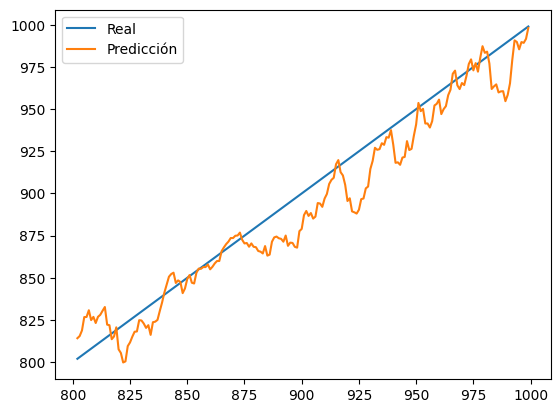

In [28]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Desescalar predicciones

# Reshape y_test to match the original number of features before inverse_transform
y_test_reshaped = y_test.reshape(-1, df_scaled.shape[1])
y_test_inverse = scaler.inverse_transform(y_test_reshaped)

# Assuming you want to plot a specific column from the inversed y_test
column_to_plot = 0  # Choose the column index you want to plot

plt.plot(df.index[train_size + time_steps:], y_test_inverse[:, column_to_plot], label='Real')
plt.plot(df.index[train_size + time_steps:], predictions[:, column_to_plot], label='Predicción')
plt.legend()
plt.show()